# Build Sprint 2: Dynamic Visualizations
This notebook here in provides visualization and experimentation for Bandersnatch Ticket 2

In [1]:
# pip install pymongo in Colab
! python -m pip install pymongo
! python -m pip install certifi --upgrade


In [25]:
from certifi import where
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import altair as alt

## Create Connection and Load Data

Establish a connection to the MongoDB database, retrieve the monster data, and convert it into a Pandas DataFrame for further analysis.

In [4]:
# Establish a connection to MongoDB using secret URI
from getpass import getpass
connection_string = getpass('Enter MONGODB_URI connection string: ')

In [5]:
client = MongoClient(connection_string,
                     tlsCAFile= where())


In [6]:
# Assign db to allow access to database
db = client.Database

In [7]:
# prompt: display list of collections present in the database

# Get the list of collection names
collection_names = db.list_collection_names()

# Print the list of collection names
collection_names

['Monsters', 'monsters']

In [8]:
# Access the monsters collection
monsters = db.monsters

In [9]:
# Retrieve the data from the monsters collection
data = list(monsters.find())

In [10]:
# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

## Data Overview
The next step involves generating insights from the dataset to prepare it for visualization. Start by:
- Counting the total number of monsters and identifying the dataset's shape (rows and columns).
- Examining the data types of all columns to confirm compatibility with visualization tools like Altair.
- Conducting basic cleaning to align the dataset with the requirements for dynamic chart generation (e.g., removing unnecessary or incompatible columns such as `_id`).

This foundational step ensures the dataset is ready for visual exploration and API integration.


In [11]:
# Check number of rows and columns
df.shape

(1000, 10)

In [12]:
# Get the first few observations from the dataframe
df.head()

,_id,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp
0,6796ce13b44523ea41423191,Wyvern,Dragon,3,Rank 1,3d4,10.92,12.16,11.05,2025-01-26 16:06:43
1,6796ce13b44523ea41423192,Balor,Demonic,3,Rank 1,3d4+3,11.34,10.83,12.10,2025-01-26 16:06:43
2,6796ce13b44523ea41423193,Efreeti,Elemental,11,Rank 2,11d6+2,67.89,64.92,64.51,2025-01-26 16:06:43
3,6796ce13b44523ea41423194,Prince of Fear,Devilkin,13,Rank 4,13d10,132.60,132.25,131.77,2025-01-26 16:06:43
4,6796ce13b44523ea41423195,Faerie Dragon,Dragon,15,Rank 0,15d2+2,29.70,30.55,30.65,2025-01-26 16:06:43


In [13]:
# Drop the `_id` Column to Align with the Deployed Web App Format
df = df.drop("_id", axis=1)
df.head()

,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp
0,Wyvern,Dragon,3,Rank 1,3d4,10.92,12.16,11.05,2025-01-26 16:06:43
1,Balor,Demonic,3,Rank 1,3d4+3,11.34,10.83,12.10,2025-01-26 16:06:43
2,Efreeti,Elemental,11,Rank 2,11d6+2,67.89,64.92,64.51,2025-01-26 16:06:43
3,Prince of Fear,Devilkin,13,Rank 4,13d10,132.60,132.25,131.77,2025-01-26 16:06:43
4,Faerie Dragon,Dragon,15,Rank 0,15d2+2,29.70,30.55,30.65,2025-01-26 16:06:43


In [14]:
# Examine Features, Data Types, and Missing Values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       1000 non-null   object 
 1   Type       1000 non-null   object 
 2   Level      1000 non-null   int64  
 3   Rarity     1000 non-null   object 
 4   Damage     1000 non-null   object 
 5   Health     1000 non-null   float64
 6   Energy     1000 non-null   float64
 7   Sanity     1000 non-null   float64
 8   Timestamp  1000 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 70.4+ KB


## Missing Values

- Total number of missing values in the dataset: 0

In [15]:
# Number of missing values in the dataset
df.isnull().sum().sum()

np.int64(0)

## Duplicated Monsters
Verify that there are no duplicated entries in the dataset.
- Count of duplicated monsters: 0

In [16]:
# Identify Duplicated Monsters Using Name and Attributes Such as Type, Level, Health, Energy, and Sanity
duplicates = df[df.duplicated(subset=['Name', 'Type', "Level", "Health", "Energy", "Sanity"])]

# Print the duplicates
print("Duplicated monsters:")
print(duplicates)

Duplicated monsters:
Empty DataFrame
Columns: [Name, Type, Level, Rarity, Damage, Health, Energy, Sanity, Timestamp]
Index: []


## Summary Statistics
Perform a detailed analysis of the dataset by generating summary statistics for all numerical columns. This includes calculating measures such as:
- Count of non-null values.
- Mean, median, and standard deviation to understand the central tendency and spread.
- Minimum and maximum values to identify the range.
- Percentiles (e.g., 25th, 50th, and 75th) to observe data distribution.

In [17]:
# Summary statistics
df.describe()

,Level,Health,Energy,Sanity
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,7.861000,39.238770,39.263190,39.213920
std,4.637584,34.139831,34.114724,34.131424
min,1.000000,1.170000,1.120000,1.410000
25%,4.000000,14.627500,14.457500,14.562500
50%,7.000000,28.245000,28.440000,28.445000
75%,11.000000,55.452500,55.272500,55.370000
max,20.000000,217.830000,213.070000,221.040000


## Data Transformation
Transform the `Timestamp` column by converting its data type from an object (string) to a proper datetime format to enable time-based operations and analysis.

In [18]:
# convert Timestamp to a datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

In [19]:
# Check `Timestamp` new data type
df.Timestamp.dtype

dtype('<M8[ns]')

In [20]:
df['Timestamp'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: Timestamp
Non-Null Count  Dtype         
--------------  -----         
1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 7.9 KB


### Outlier Detection
Use a Boxplot to visually detect potential outliers in the dataset.
- Apply the Interquartile Range (IQR) method to systematically identify outliers within numerical columns.
    - Outliers are data points that fall below the lower bound or above the upper bound.
    - The bounds are determined using the formula:
        - **Lower Bound** = Q1 - 1.5 × IQR
        - **Upper Bound** = Q3 + 1.5 × IQR

        Outliers in column 'Health':
            Lower Bound: -46.61, Upper Bound: 116.69
            Number of Outliers: 37

        Outliers in column 'Energy':
            Lower Bound: -46.76, Upper Bound: 116.5
            Number of Outliers: 37

        Outliers in column 'Sanity':
            Lower Bound: -46.65, Upper Bound: 116.58
            Number of Outliers: 38

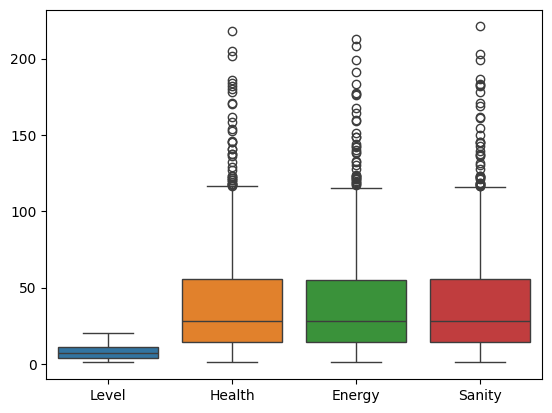

In [26]:
# Boxplot visualization to look for outliers
sns.boxplot(data=df)
plt.show();

In [27]:
# Using IQR (Interquartile Range) to Identify Outliers

# Iterate over each numerical column in the DataFrame
for column in df.select_dtypes(include=np.number):
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for detecting outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify the outliers in the current column
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    # Display the results for the current column
    print(f"Outliers in column '{column}':")
    print(f"Lower Bound: {round(lower_bound, 2)}, Upper Bound: {round(upper_bound, 2)}")
    print(f"Number of Outliers: {outliers.shape[0]}")
    display(outliers)
    print()  # Add spacing for readability


Outliers in column 'Level':
Lower Bound: -6.5, Upper Bound: 21.5
Number of Outliers: 0


,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp



Outliers in column 'Health':
Lower Bound: -46.61, Upper Bound: 116.69
Number of Outliers: 37


,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp
3,Prince of Fear,Devilkin,13,Rank 4,13d10,132.60,132.25,131.77,2025-01-26 16:06:43
5,Silver Demon,Demonic,14,Rank 5,14d12+2,170.52,167.37,168.67,2025-01-26 16:06:43
63,Ruby Faerie,Fey,12,Rank 5,12d12+1,141.07,148.87,145.54,2025-01-26 16:06:43
88,Pseudodragon,Dragon,12,Rank 4,12d10,118.13,115.50,116.63,2025-01-26 16:06:43
100,Quasit,Demonic,18,Rank 4,18d10+2,180.17,176.05,182.96,2025-01-26 16:06:43
136,Poltergeist,Undead,15,Rank 3,15d8+2,121.51,121.22,122.50,2025-01-26 16:06:43
158,Steam Spirit,Fey,17,Rank 5,17d12+1,201.95,208.58,199.24,2025-01-26 16:06:43
163,Ghoul,Undead,15,Rank 3,15d8,117.47,120.89,117.76,2025-01-26 16:06:43
234,Smoke Archfey,Fey,13,Rank 4,13d10+2,129.30,130.34,130.49,2025-01-26 16:06:43
304,Quasit,Demonic,15,Rank 3,15d8+1,119.29,118.72,118.07,2025-01-26 16:06:43



Outliers in column 'Energy':
Lower Bound: -46.76, Upper Bound: 116.5
Number of Outliers: 37


,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp
3,Prince of Fear,Devilkin,13,Rank 4,13d10,132.60,132.25,131.77,2025-01-26 16:06:43
5,Silver Demon,Demonic,14,Rank 5,14d12+2,170.52,167.37,168.67,2025-01-26 16:06:43
63,Ruby Faerie,Fey,12,Rank 5,12d12+1,141.07,148.87,145.54,2025-01-26 16:06:43
100,Quasit,Demonic,18,Rank 4,18d10+2,180.17,176.05,182.96,2025-01-26 16:06:43
136,Poltergeist,Undead,15,Rank 3,15d8+2,121.51,121.22,122.50,2025-01-26 16:06:43
158,Steam Spirit,Fey,17,Rank 5,17d12+1,201.95,208.58,199.24,2025-01-26 16:06:43
163,Ghoul,Undead,15,Rank 3,15d8,117.47,120.89,117.76,2025-01-26 16:06:43
234,Smoke Archfey,Fey,13,Rank 4,13d10+2,129.30,130.34,130.49,2025-01-26 16:06:43
304,Quasit,Demonic,15,Rank 3,15d8+1,119.29,118.72,118.07,2025-01-26 16:06:43
312,Magma Elemental,Elemental,15,Rank 3,15d8,116.24,117.49,122.55,2025-01-26 16:06:43



Outliers in column 'Sanity':
Lower Bound: -46.65, Upper Bound: 116.58
Number of Outliers: 38


,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp
3,Prince of Fear,Devilkin,13,Rank 4,13d10,132.60,132.25,131.77,2025-01-26 16:06:43
5,Silver Demon,Demonic,14,Rank 5,14d12+2,170.52,167.37,168.67,2025-01-26 16:06:43
63,Ruby Faerie,Fey,12,Rank 5,12d12+1,141.07,148.87,145.54,2025-01-26 16:06:43
88,Pseudodragon,Dragon,12,Rank 4,12d10,118.13,115.50,116.63,2025-01-26 16:06:43
100,Quasit,Demonic,18,Rank 4,18d10+2,180.17,176.05,182.96,2025-01-26 16:06:43
136,Poltergeist,Undead,15,Rank 3,15d8+2,121.51,121.22,122.50,2025-01-26 16:06:43
158,Steam Spirit,Fey,17,Rank 5,17d12+1,201.95,208.58,199.24,2025-01-26 16:06:43
163,Ghoul,Undead,15,Rank 3,15d8,117.47,120.89,117.76,2025-01-26 16:06:43
234,Smoke Archfey,Fey,13,Rank 4,13d10+2,129.30,130.34,130.49,2025-01-26 16:06:43
304,Quasit,Demonic,15,Rank 3,15d8+1,119.29,118.72,118.07,2025-01-26 16:06:43


## Correlation Analysis

Create a correlation matrix or correlogram to gain more insights into the relationships and patterns between every feature of the matrix.

- Use pairplot from seaborn and build a scatter matrix with Altair



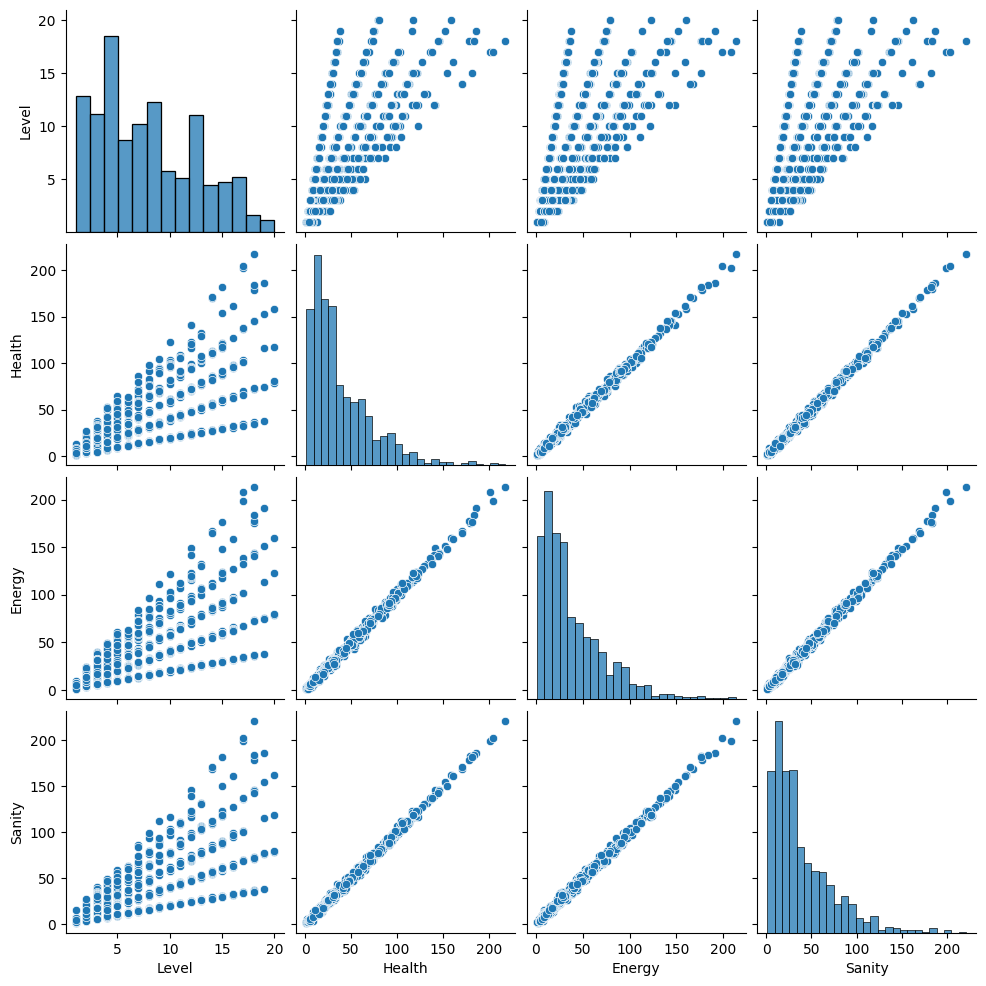

In [28]:
# Correlation matrix using Seaborn
sns.pairplot(df)
plt.show();

In [32]:
# Scatter matrix using Altair

alt.Chart(df).mark_circle(size=60).encode(
    alt.X(alt.repeat("column"), type="quantitative"),  # Assign repeated columns to the x-axis
    alt.Y(alt.repeat("row"), type="quantitative")  # Assign repeated rows to the y-axis
).properties(
    width=200,  # Set the width of each chart in the scatter matrix
    height=200  # Set the height of each chart in the scatter matrix
).repeat(
    row=["Level", "Health", "Energy", "Sanity"],  # Features for the rows
    column=["Level", "Health", "Energy", "Sanity"]  # Features for the columns
).interactive()  # Enable interactivity for the chart


alt.RepeatChart(...)

## Scatterplot Visualization <> "Energy by Health for Rarity"
- Display the relationship between `Health` and `Energy`, categorized by `Rarity`. Create separate scatterplots using **Matplotlib**, **Seaborn**, and **Altair** for comparison.
- Illustrate the relationship between `Sanity` and `Health`, categorized by `Level`, using **Altair** for an interactive visualization.

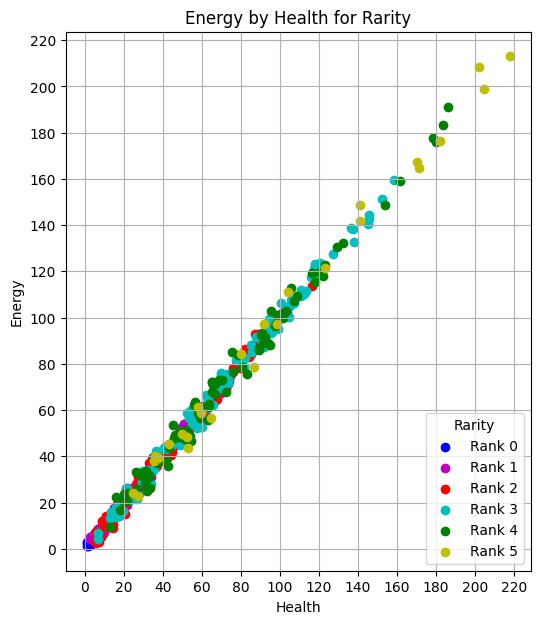

In [33]:
# Scatterplot  MATPLOT Visualization


# Set up the figure and its size
fig = plt.figure(figsize=(6, 7))
ax = plt.axes()

# Configure tick intervals for both axes
ax.set_xticks(np.arange(0, 240, 20))
ax.set_yticks(np.arange(0, 240, 20))

# Define the order of rarity levels and assign custom colors
hue_order = ["Rank 0", "Rank 1", "Rank 2", "Rank 3", "Rank 4", "Rank 5"]
custom_palette = ["b", "m", "r", "c", "g", "y"]

# Plot data points for each rarity level with corresponding colors
for hue, color in zip(hue_order, custom_palette):
    indices = df.Rarity == hue  # Filter rows by current rarity level
    plt.scatter(
        df.loc[indices, "Health"],
        df.loc[indices, "Energy"],
        c=color,
        label=hue
    )

# Set plot title and axis labels
plt.title("Energy by Health for Rarity")
plt.xlabel("Health")
plt.ylabel("Energy")

# Add gridlines and legend
plt.grid()
plt.legend(title="Rarity", loc="lower right", markerscale=1)

# Render the plot
plt.show()


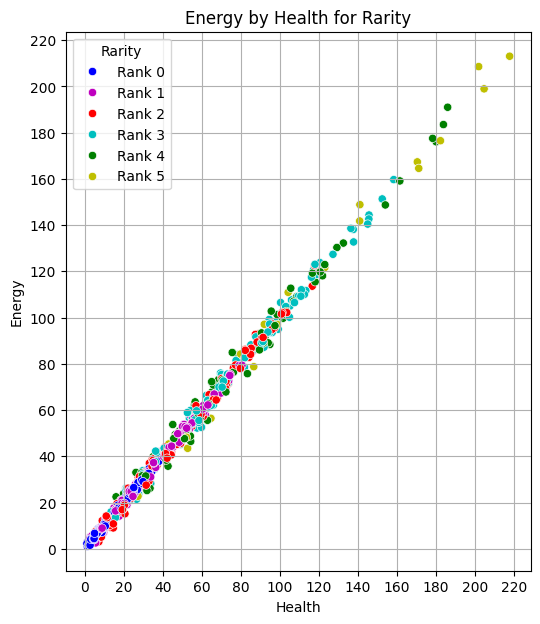

In [36]:
# Scatterplot SEABORN Visualization

# Set up the figure and axis
fig = plt.figure(figsize=(6, 7))
ax = plt.axes()

# Configure tick intervals for both axes
ax.set_xticks(np.arange(0, 240, 20))
ax.set_yticks(np.arange(0, 240, 20))

# Define the order of categories and custom colors for rarity levels
hue_order = ["Rank 0", "Rank 1", "Rank 2", "Rank 3", "Rank 4", "Rank 5"]
custom_palette = ["b", "m", "r", "c", "g", "y"]

# Create the scatterplot using Seaborn
sns.scatterplot(
    x="Health",
    y="Energy",
    hue="Rarity",
    hue_order=hue_order,
    palette=custom_palette,
    data=df
).set(title="Energy by Health for Rarity")

# Add axis labels
plt.xlabel("Health")
plt.ylabel("Energy")

# Add gridlines to the plot
plt.grid()

# Display the plot
plt.show()


In [38]:
# Scatterplot Visualization using Altair

alt.Chart(df, title="Energy by Health for Rarity").mark_circle(size=60).encode(
    x="Health",
    y="Energy",
    color="Rarity",
    tooltip=[
        "Name",
        "Type",
        "Level",
        "Rarity",
        "Damage",
        "Health",
        "Energy",
        "Sanity",
        "Timestamp"
    ]
).properties(
    width=600,  # Set chart width
    height=700  # Set chart height
).interactive()


alt.Chart(...)

## Summary

This notebook provides an analytical exploration of the monster dataset as part of Bandersnatch Ticket 2. The objective was to perform data quality checks, including identifying outliers and duplicates, and to generate visualizations that highlight key patterns and relationships within the dataset.

To ensure data integrity, I verified that there were no missing values or duplicates. Outliers were identified using the interquartile range (IQR) method, revealing notable extreme values in the `Health`, `Energy`, and `Sanity` columns. However, these outliers were not treated or removed during this analysis.

One key finding from the scatter matrix analysis was the observation of a positive correlation between `Health` and `Energy`. Monsters with higher `Health` values demonstrated correspondingly high `Energy`. This insight provides valuable context for deeper statistical exploration, such as calculating correlation coefficients to quantify relationships between attributes.

The visualizations in this notebook were designed to provide an intuitive understanding of the data and test approaches to dynamic charting. This exploration lays the groundwork for implementing further functionality, such as integrating dynamic visualizations and APIs into the Bandersnatch web application. Future efforts should focus on:
- Addressing outliers for more robust analyses.
- Quantifying relationships through statistical metrics.
- Aligning visualizations with the application's user experience and design.

This analysis fulfills the chart experimentation portion of the ticket requirements.

